In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from multiprocessing import cpu_count
from tqdm.autonotebook import tqdm

from ..Logger import MetricsLogger

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [0]:
# Download MNIST dataset and make datasets
root_dir = "../example"
data_dir = root_dir + "/data"
transform = transforms.ToTensor()
train_ds = datasets.MNIST(data_dir, train=True, transform=transform, 
                               download=True)
test_ds = datasets.MNIST(data_dir, train=False, transform=transform, 
                              download=True)

In [0]:
# Make train and test Dataloader
batch_size = 128
num_workers = cpu_count()
train_dl = DataLoader(train_ds, batch_size=batch_size, 
                         shuffle=True, num_workers=num_workers)
test_dl = DataLoader(test_ds, batch_size=batch_size, 
                        shuffle=False, num_workers=num_workers)

In [0]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, 3), nn.BatchNorm2d(32))
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 3), nn.BatchNorm2d(64))
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.dropout1(x.view(-1, self.fc1.in_features))
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        return F.log_softmax(self.fc2(x), 1)

In [0]:
def accuracy(y, y_hat):
    """Compute the accuracy for a batch of prediction and target."""
    _, y_pred = torch.max(y_hat, 1)
    return (y_pred == y).cpu().numpy().mean()

In [0]:
class Trainer(object):
    def __init__(self, model, optimizer, loss_fn, train_dl, val_dl, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.device = device
        self.logger = MetricsLogger()
        
    def train(self, epochs):
        for epoch in tqdm(range(epochs)):
            self.logger.reset()

            self.model.train()
            for x, y in tqdm(self.train_dl, leave=False):
                x, y = x.to(self.device), y.to(self.device)
                y_hat = self.model(x)
                loss = self.loss_fn(y_hat, y)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                self.logger.update({"train_loss": loss.item(), 
                                    "train_acc": accuracy(y, y_hat)})

            self.model.eval()
            with torch.no_grad():
                for x, y in self.val_dl:
                    x, y = x.to(self.device), y.to(self.device)

                    y_hat = self.model(x)
                    loss = self.loss_fn(y_hat, y)

                    self.logger.update({"test_loss": loss.item(), 
                                        "test_acc": accuracy(y, y_hat)})

In [0]:
# Instanciate model and set optimizer and loss function
model = ConvNet()
loss_fn = F.nll_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

trainer = Trainer(model, optimizer, loss_fn, train_dl, test_dl, device)

In [9]:
trainer.train(10)

train_loss: 0.2074 - train_acc: 0.9373 - test_loss: 0.0588 - test_acc: 0.9800

train_loss: 0.0898 - train_acc: 0.9726 - test_loss: 0.0426 - test_acc: 0.9854

train_loss: 0.0722 - train_acc: 0.9781 - test_loss: 0.0323 - test_acc: 0.9896

train_loss: 0.0588 - train_acc: 0.9814 - test_loss: 0.0340 - test_acc: 0.9883

train_loss: 0.0536 - train_acc: 0.9840 - test_loss: 0.0399 - test_acc: 0.9864

train_loss: 0.0456 - train_acc: 0.9850 - test_loss: 0.0314 - test_acc: 0.9893

train_loss: 0.0417 - train_acc: 0.9868 - test_loss: 0.0311 - test_acc: 0.9906

train_loss: 0.0373 - train_acc: 0.9880 - test_loss: 0.0284 - test_acc: 0.9911

train_loss: 0.0343 - train_acc: 0.9892 - test_loss: 0.0280 - test_acc: 0.9905

train_loss: 0.0314 - train_acc: 0.9896 - test_loss: 0.0253 - test_acc: 0.9918


In [10]:
trainer.logger.log_df

,test_acc,test_loss,train_acc,train_loss
0,0.980024,0.058717,0.937328,0.207390
1,0.985463,0.042241,0.972598,0.089818
2,0.989715,0.031614,0.978128,0.072201
3,0.988430,0.034549,0.981360,0.058774
4,0.986551,0.039367,0.984020,0.053617
5,0.989419,0.030992,0.985030,0.045615
6,0.990704,0.029887,0.986774,0.041699
7,0.991199,0.028069,0.988023,0.037274
8,0.990605,0.027947,0.989217,0.034319


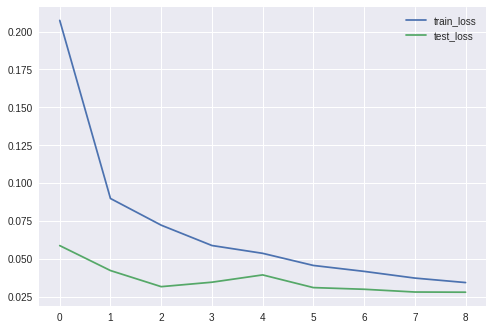

In [11]:
trainer.logger.log_df[["train_loss", "test_loss"]].plot()

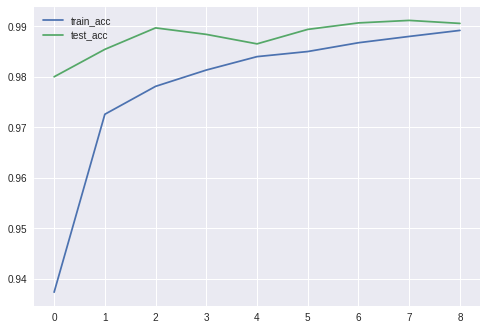

In [12]:
trainer.logger.log_df[["train_acc", "test_acc"]].plot()